# Quick look at NY Phil concert program data

Eamonn Bell, Columbia University `<epb2125@columbia.edu>`

---


Work in progress. Some interesting questions worth asking are bolded if there's anything in the notebook that moves towards a solution.

- What composers tend to get programmed together?
- **Where did the orchestra play?**
- **What does 'composer discovery' look like?** Can we spot faddish composers by the shape of their performance frequency?
- **Who played with whom over the course of the existence of the orchestra?** The social network of performers.
- What are the significant differences between tour and subscription concert programs in general?
- What conductors prefer which works?
- What are the genres of the most-programmed works?
- What time do concerts tend to start at?

---

## Acknowledgements

Thanks to https://github.com/bmcfee for the parsing code. The dataset this notebook is based on was released under CC0 1.0 Universal.

In [32]:
import lxml
import pandas as pd

import urllib2  

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import json

import numpy as np
import collections
import glob

from pprint import pprint
from IPython.display import HTML, Image
from lxml import etree, objectify


%matplotlib inline

In [2]:
!git submodule update

In [3]:
# Author: https://github.com/bmcfee/nycphil (Brian McFee)

def parse_programs(programs):
    
    return [parse_program(x) for x in programs]

def parse_program(program):
    
    dispatch = dict(concertInfo=parse_concertInfo,
                    worksInfo=parse_worksInfo)
    data = dict()
    
    for child in program.getchildren():
        if child.tag in dispatch:
            data[child.tag] = dispatch[child.tag](child)
        else:
            data[child.tag] = child.text
            
    return data
            
def parse_concertInfo(concertInfo):
    data = dict()
    
    for child in concertInfo.getchildren():
        data[child.tag] = child.text
    
    return data

def parse_worksInfo(worksInfo):
    
    data = list()
    
    for child in worksInfo.getchildren():
        data.append(parse_work(child))
            
    return data

def parse_work(work):
    
    dispatch = dict(soloists=parse_soloists)
    data = dict()
    
    for child in work.getchildren():
        if child.tag in dispatch:
            data[child.tag] = dispatch[child.tag](child)
        else:
            data[child.tag] = child.text
            
    return data

def parse_soloists(soloists):
    data = list()
    for child in soloists.getchildren():
        data.append(parse_soloist(child))
    return data

def parse_soloist(soloist):
    data = dict()
    
    for child in soloist.getchildren():
        data[child.tag] = child.text
    
    return data

def flatten(d):
    
    works = d.pop('worksInfo', [])
    concertInfo = d.pop('concertInfo', [])
       
    out = []
    for w in works:
        out.append(concertInfo.copy())
        
        # Added this to get soloist's names in. Dirty.
        
        soloists = w.get('soloists', None)
        
        if soloists is not None:
            soloists_names = [s.get('soloistName') for s in soloists if s.get('soloistName') is not None]
            soloists_tsv = "\t".join(soloists_names)
            out[-1].update({'soloists_tsv' : soloists_tsv})
            
        w.pop('soloists', [])
        out[-1].update(d)
        out[-1].update(w)
        
    return out

def load_programs():
    # We need this to handle badly formatted &'s in strings
    parser = etree.XMLParser(recover=True)

    fd = []
    globbed = sorted(glob.glob('./PerformanceHistory/Programs/*.xml'))
    
    for xmlfile in globbed:
        obj = objectify.parse(xmlfile, parser=parser)
        dix = parse_programs(obj.getroot())
        for _ in dix:
            fd.extend(flatten(_))
    df = pd.DataFrame.from_records(fd)
    df['oldDate'] = df['Date']
    df['Date'] = pd.to_datetime(df['Date'])

    return df

In [4]:
df = load_programs()

In [5]:
df.head()

,Date,Location,Time,Venue,composerName,conductorName,eventType,id,interval,movement,orchestra,programID,season,soloists_tsv,workTitle,oldDate
0,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Beethoven, Ludwig van","Hill, Ureli Corelli",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,NaN,New York Philharmonic,3853,1842-43,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",1842-12-07T05:00:00Z
1,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Weber, Carl Maria Von","Timm, Henry C.",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,"""Ozean, du Ungeheuer"" (Ocean, thou mighty mons...",New York Philharmonic,3853,1842-43,"Otto, Antoinette",OBERON,1842-12-07T05:00:00Z
2,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Hummel, Johann",NaN,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,NaN,New York Philharmonic,3853,1842-43,"Scharfenberg, William\tHill, Ureli Corelli\tDe...","QUINTET, PIANO, D MINOR, OP. 74",1842-12-07T05:00:00Z
3,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,NaN,NaN,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,Intermission,NaN,New York Philharmonic,3853,1842-43,NaN,NaN,1842-12-07T05:00:00Z
4,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Weber, Carl Maria Von","Etienne, Denis G.",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,Overture,New York Philharmonic,3853,1842-43,NaN,OBERON,1842-12-07T05:00:00Z


In [6]:
len(df)



164622

In [7]:
# We don't care for the moment about movements

df = df.drop_duplicates(subset=['programID', 'workTitle'])
len(df)

73880

---
## Number of works performed by composers over time

In [8]:
# Get, e.g., top 5 composers by performances of all time

sample_list = list(df.composerName.value_counts()[:5].index)

In [9]:
sample = df[df.composerName.isin(sample_list)]

In [10]:
all_works = df.groupby(df['Date'].map(lambda x:x.year)).count()
yearly_counts = pd.Series(all_works['id'], index=all_works.index)

### Raw counts

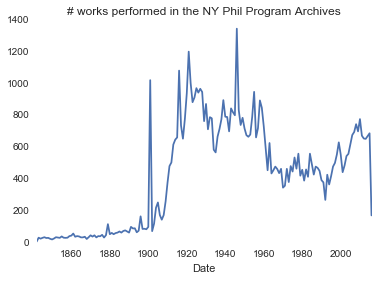

In [11]:
yearly_counts.plot()
plt.title('# works performed in the NY Phil Program Archives')
plt.show()

In [12]:
orchestras = list(df.orchestra.value_counts().keys())


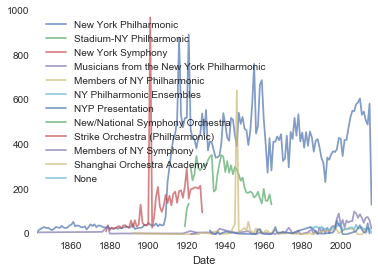

In [13]:
for orch in orchestras:
    one_orch = df[df.orchestra == orch]
    aggregate = one_orch.groupby(one_orch['Date'].map(lambda x:x.year)).count()
    orch_counts = pd.Series(aggregate['id'], index=aggregate.index, name=orch)
    orch_counts.plot(legend=True, label=orch, alpha=0.7)

In [14]:
df = df[df.orchestra == 'New York Philharmonic']
len(df)

51022

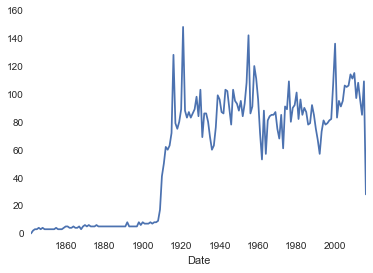

In [15]:
all_programs = df.groupby(df['Date'].map(lambda x:x.year)).programID.nunique()
all_programs.plot()

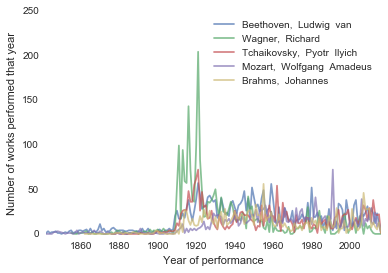

In [16]:
for composer in sample_list:
    one_composer = df[df.composerName == composer]
    aggregate = one_composer.groupby(one_composer['Date'].map(lambda x:x.year)).count()
    composer_counts = pd.Series(aggregate['id'], index=aggregate.index, name=composer)
    composer_counts.plot(legend=True, label=composer, alpha=0.7)

plt.ylabel('Number of works performed that year')
plt.xlabel('Year of performance')

### As a proportion of all works played that year

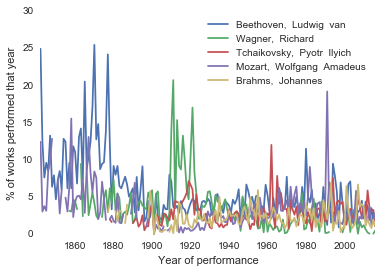

In [17]:
for name in sample_list:
    one_composer = df[df.composerName == name]
    aggregate = one_composer.groupby(one_composer['Date'].map(lambda x:x.year)).count()
    composer_counts = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    composer_counts_prop = composer_counts.divide(yearly_counts) * 100
    composer_counts_prop.plot(legend=True, label=name)

plt.ylabel('% of works performed that year')
plt.xlabel('Year of performance')

### Discovery of new composers

In [18]:
df.composerName.value_counts()[:10]

Beethoven,  Ludwig  van        3138
Wagner,  Richard               2564
Tchaikovsky,  Pyotr  Ilyich    2196
Mozart,  Wolfgang  Amadeus     1862
Brahms,  Johannes              1684
Strauss,  Richard              1199
Bach,  Johann  Sebastian        908
Mendelssohn,  Felix             859
Dvorak,  Antonín                845
Ravel,  Maurice                 822
Name: composerName, dtype: int64

In [19]:
def composer_counts_by_name(name):
    composer = df[df.composerName == name]
    aggregate = composer.groupby(composer['Date'].map(lambda x:x.year)).count()
    annual_composer_counts = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    return annual_composer_counts
    
def plot_composer_by_name(name):
    composer_counts_by_name(name).plot(legend=True, label=name)

In [20]:
a = composer_counts_by_name('Milhaud,  Darius')

In [21]:
a.index = pd.to_datetime(a.index,format="%Y")
a = a.resample('D').mean()
a.interpolate(inplace=True)


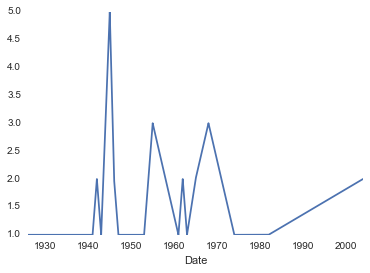

In [22]:
a.plot()

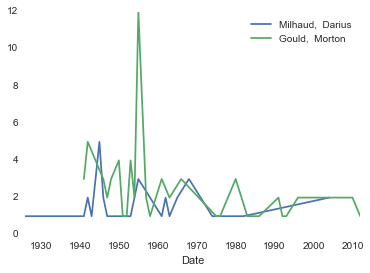

In [23]:
plot_composer_by_name('Milhaud,  Darius')
plot_composer_by_name('Gould,  Morton')

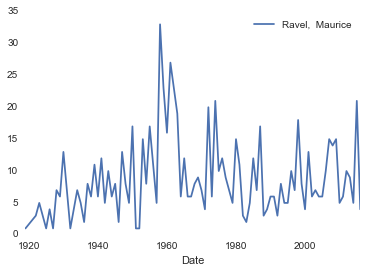

In [24]:
plot_composer_by_name('Ravel,  Maurice')

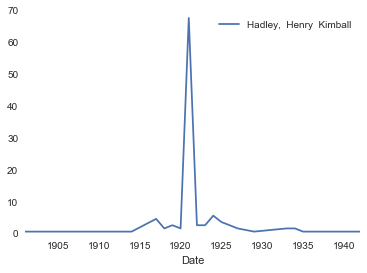

In [25]:
plot_composer_by_name('Hadley,  Henry  Kimball')

In [25]:
hadley = df[df.composerName == 'Hadley,  Henry  Kimball']
hadley.groupby([df.workTitle], sort=True).count()['id'].order(ascending=False).head(10)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from IPython.kernel.zmq import kernelapp as app


workTitle
CULPRIT FAY RHAPSODY, OP. 62                                   57
SALOME, OP. 55                                                 15
OCEAN, THE, OP. 99                                              8
SYMPHONY NO. 4, D MINOR, OP. 64, "NORTH, EAST, SOUTH, WEST"     5
SILHOUETTES, OP.77 (ARR. Roberts)                               5
IN BOHEMIA                                                      5
SYMPHONY NO. 3, B MINOR, OP. 60                                 3
LUCIFER, OP. 66                                                 3
SYMPHONY NO. 2, F MINOR, OP.30 (FOUR SEASONS)                   2
SYMPHONIC FANTASIE, E FLAT MAJOR, OP. 46                        2
Name: id, dtype: int64

---

## Time series clustering

In [28]:
def composer_counts_by_name_resample(name):
    composer = df[df.composerName == name]
    aggregate = composer.groupby(composer['Date'].map(lambda x:x.year)).count()
    a = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    a.index = pd.to_datetime(a.index,format="%Y")
    a = a.resample('A', ).mean()
    a = a.fillna(0)
    return a

In [50]:
composer_counts_by_name_resample(search_composer('Kimball'))

Date
1901-12-31     1.0
1902-12-31     0.0
1903-12-31     0.0
1904-12-31     0.0
1905-12-31     0.0
1906-12-31     0.0
1907-12-31     0.0
1908-12-31     1.0
1909-12-31     0.0
1910-12-31     0.0
1911-12-31     1.0
1912-12-31     1.0
1913-12-31     1.0
1914-12-31     1.0
1915-12-31     0.0
1916-12-31     0.0
1917-12-31     5.0
1918-12-31     2.0
1919-12-31     3.0
1920-12-31     2.0
1921-12-31    68.0
1922-12-31     3.0
1923-12-31     3.0
1924-12-31     6.0
1925-12-31     4.0
1926-12-31     0.0
1927-12-31     2.0
1928-12-31     0.0
1929-12-31     1.0
1930-12-31     0.0
1931-12-31     0.0
1932-12-31     0.0
1933-12-31     2.0
1934-12-31     2.0
1935-12-31     1.0
1936-12-31     0.0
1937-12-31     0.0
1938-12-31     0.0
1939-12-31     1.0
1940-12-31     0.0
1941-12-31     0.0
1942-12-31     1.0
Freq: A-DEC, Name: Hadley,  Henry  Kimball, dtype: float64

In [29]:
top_ten = df.composerName.value_counts()[:1000].keys()
series = [(c,composer_counts_by_name_resample(c)) for c in top_ten]

In [30]:
composers = [s[0] for s in series]
values = [list(s[1].values) for s in series]

In [33]:
midpoints = [1798.5,
1848,
1866.5,
1773.5,
1865,
1906.5,
1717.5,
1828,
1872.5,
1906,
1926.5,
1836,
1812.5,
1890,
1848.5,
1833,
1922,
1770.5,
1806,
1850,
1885.5,
1945,
1954,
1911,
1917.5,
1862,
1908,
1878,
1876,
1940.5,
1850,
1830,
1913,
1722,
1856.5,
1860,
1857,
1860,
1893,
1875,
1945.5,
1856,
1829.5,
1895.5,
1911,
1914,
1854,
1907.5,
1879,
1709.5]


with open('midpoints.json', 'w') as f:
    json.dump(midpoints, f)

In [34]:
import json

with open('series.json', 'w') as f:
    json.dump(values, f)

In [35]:
with open('composers.json', 'w') as f:
    json.dump(composers, f)

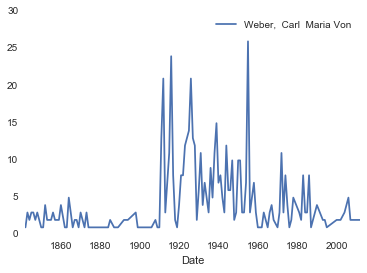

In [36]:
plot_composer_by_name(composers[18])

Switch to R and use `dtwclust` and state-of-the-art http://www.cs.columbia.edu/~gravano/Papers/2015/sigmod2015.pdf

Back into Python


In [37]:
def search_composer(q):
    return [c for c in composers if q in c][0]

def search_piece(q):
    return [p for p in pieces if q in p][0]

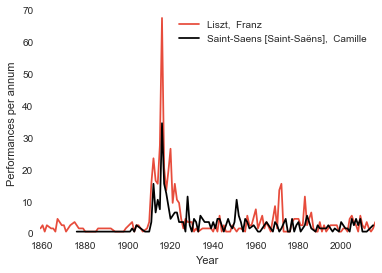

In [45]:
with sns.color_palette(["#e74c3c", "#020202"]):
    plot_composer_by_name(search_composer('Liszt'))
    plot_composer_by_name(search_composer('Saint-Sa'))
plt.ylabel("Performances per annum")
plt.xlabel("Year")
plt.savefig('figs/LisztSS.svg')

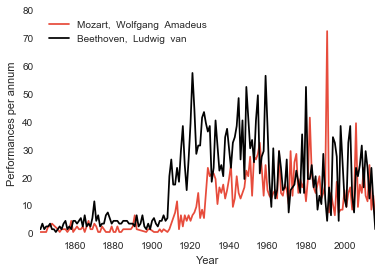

In [48]:
with sns.color_palette(["#e74c3c", "#020202"]):
    plot_composer_by_name(search_composer('Mozart'))
    plot_composer_by_name(search_composer('Beeth'))
plt.ylabel("Performances per annum")
plt.xlabel("Year")
plt.savefig('figs/MozB.svg')

In [ ]:
import scipy

for composer in composers:
    s = composer_counts_by_name_resample(composer)
    
    F_s = np.fft.rfft(s.values)
    freq = np.fft.rfftfreq(len(s.values), d=0.5)
    
    plt.plot(freq, np.abs(F_s))
    plt.title(u'DFT {}'.format(composer))
    plt.show()

### Time series analysis of individual pieces

In [247]:
df.head()

,Date,Location,Time,Venue,composerName,conductorName,eventType,id,interval,movement,orchestra,programID,season,soloists_tsv,workTitle,oldDate,comp_and_title
0,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Beethoven, Ludwig van","Hill, Ureli Corelli",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,NaN,New York Philharmonic,3853,1842-43,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",1842-12-07T05:00:00Z,"Beethoven, Ludwig van SYMPHONY NO. 5 IN C MI..."
1,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Weber, Carl Maria Von","Timm, Henry C.",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,"""Ozean, du Ungeheuer"" (Ocean, thou mighty mons...",New York Philharmonic,3853,1842-43,"Otto, Antoinette",OBERON,1842-12-07T05:00:00Z,"Weber, Carl Maria Von OBERON"
2,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Hummel, Johann",NaN,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,NaN,New York Philharmonic,3853,1842-43,"Scharfenberg, William\tHill, Ureli Corelli\tDe...","QUINTET, PIANO, D MINOR, OP. 74",1842-12-07T05:00:00Z,"Hummel, Johann QUINTET, PIANO, D MINOR, OP. 74"
3,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,NaN,NaN,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,Intermission,NaN,New York Philharmonic,3853,1842-43,NaN,NaN,1842-12-07T05:00:00Z,NaN
5,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Rossini, Gioachino","Timm, Henry C.",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,Duet,New York Philharmonic,3853,1842-43,"Otto, Antoinette\tHorn, Charles Edward",ARMIDA,1842-12-07T05:00:00Z,"Rossini, Gioachino ARMIDA"


In [276]:
piece_counts = df.comp_and_title.value_counts()
pieces = piece_counts.keys()[:1000]

In [291]:
def piece_counts_by_name(name):
    c = df[df.comp_and_title == name]
    aggregate = c.groupby(c['Date'].map(lambda x:x.year)).count()
    a = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    return a

def piece_counts_by_name_resample(name):
    c = df[df.comp_and_title == name]
    aggregate = c.groupby(c['Date'].map(lambda x:x.year)).count()
    a = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    a.index = pd.to_datetime(a.index,format="%Y")
    a = a.resample('A', ).mean()
    a = a.fillna(0)
    return a

def plot_piece_by_name(name):
    piece_counts_by_name(name).plot(legend=True, label=name)

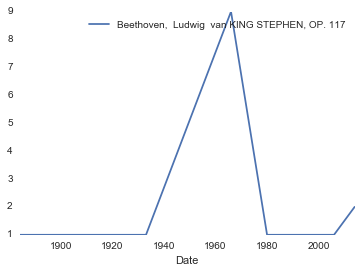

In [316]:
plot_piece_by_name(search_piece("van KING STEPHEN"))

In [278]:
piece_series = [piece_counts_by_name_resample(p) for p in pieces]

In [280]:
piece_values = [list(s.values) for s in piece_series]

In [285]:
with open('piece_series.json', 'w') as f:
    json.dump(piece_values, f)
    
with open('pieces.json', 'w') as f:
    json.dump(list(pieces.values), f)


In [315]:
piece_counts[search_piece('Hector CORSAIRE OVERTURE')]

42

### DFT on pieces

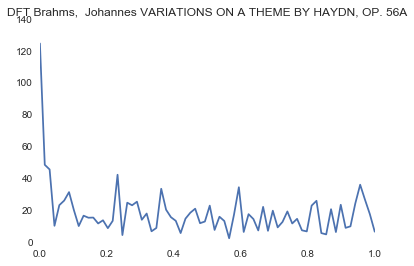

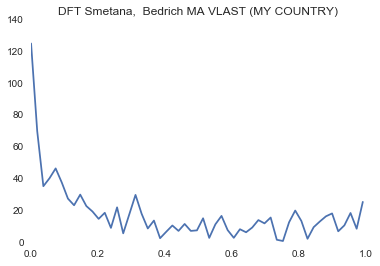

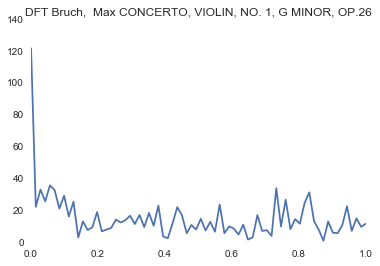

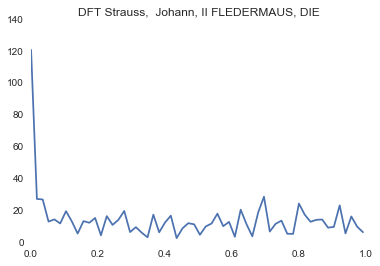

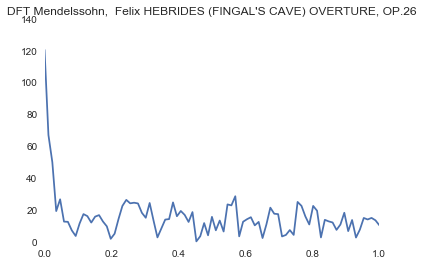

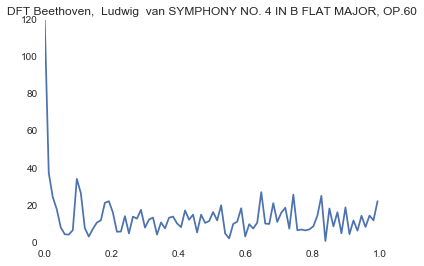

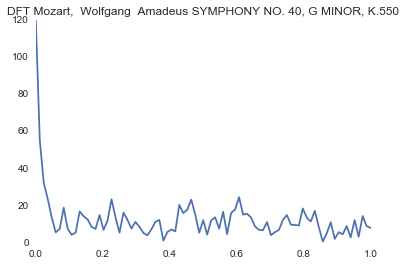

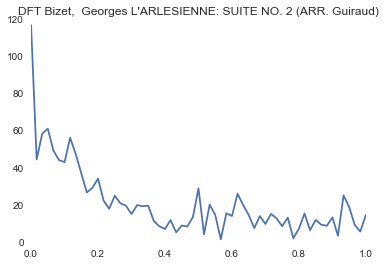

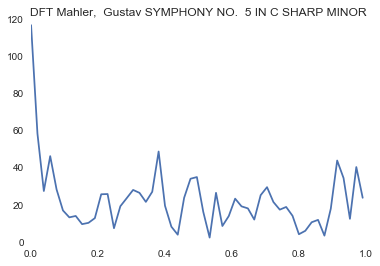

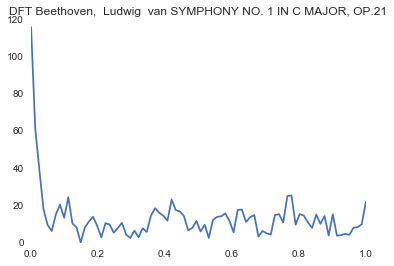

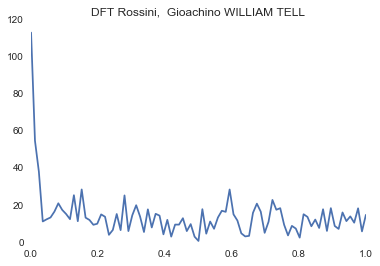

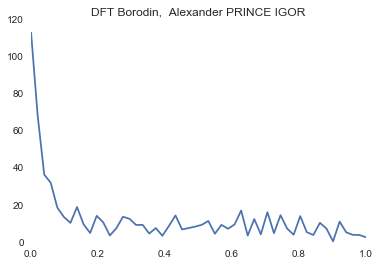

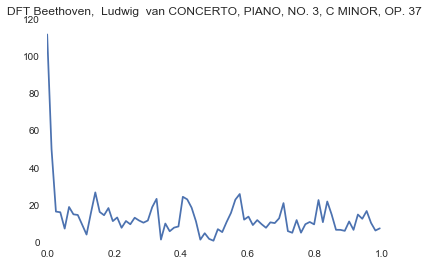

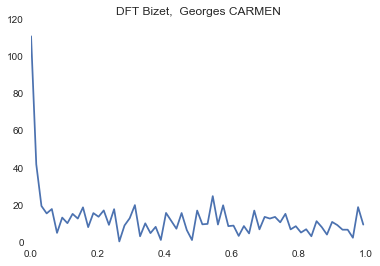

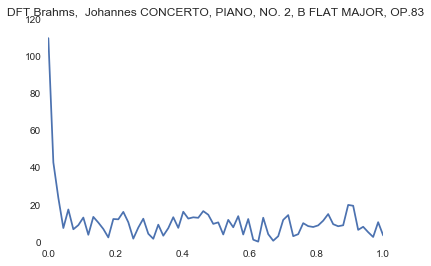

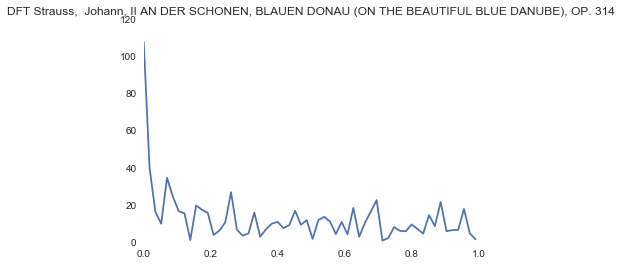

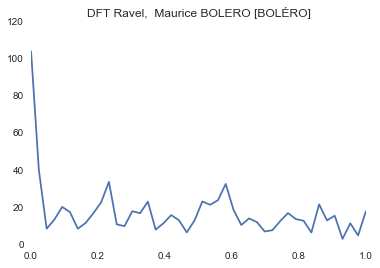

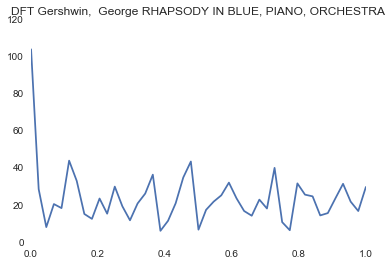

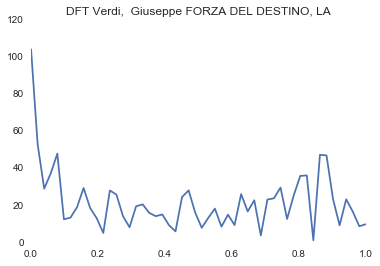

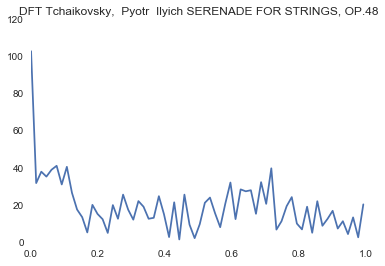

In [273]:
for p in pieces[80:100]:
    s = piece_counts_by_name_resample(p)
    
    F_s = np.fft.rfft(s.values)
    freq = np.fft.rfftfreq(len(s.values), d=0.5)
    
    plt.plot(freq, np.abs(F_s))
    plt.title(u'DFT {}'.format(p))
    plt.show()

## Sounds of the __

Represent each year as a vector and apply tf-idf

In [208]:
df.year = df.Date.apply(lambda x:x.year)
all_years = list(set(df.year.values))
# df['comp_and_title'] = df.composerName
df['comp_and_title'] = df.composerName + " " + df.workTitle

In [209]:
import math

yearly = {}

for y in all_years:
    scoped_to_year = df[df.year == y]
    
    pieces = list(scoped_to_year.comp_and_title.values)
    pieces = filter(lambda x:isinstance(x, basestring), pieces)
    yearly[y] = pieces

In [211]:
import json

with open('yearly.json', 'w') as f:
    json.dump(yearly, f)

In [212]:
from collections import defaultdict

def yearly_to_decadely(yearly):
    decadely = defaultdict(list)
    for year, series in yearly.iteritems():
        decade = (year // 10) * 10
        decadely[decade].extend(series)
    
    return dict(decadely)

In [213]:
decadely = yearly_to_decadely(yearly)
data = decadely

In [214]:
decadely.keys()

[1920,
 1860,
 1990,
 1930,
 1870,
 2000,
 1940,
 1880,
 2010,
 1950,
 1890,
 1960,
 1900,
 1840,
 1970,
 1910,
 1850,
 1980]

In [215]:
import gensim

In [216]:
d = gensim.corpora.Dictionary(documents=data.values())
corpus = [d.doc2bow(p) for p in data.values()]

def reverse_dict(in_dict):
    new = {}
    for k, v in in_dict.items():
        new[v] = k
    return new

In [217]:
id2token = reverse_dict(d.token2id)

In [218]:
tfidf = gensim.models.TfidfModel(corpus)

In [219]:
decade_raw_top = []

for year, prog in data.items():
    top = sorted(d.doc2bow(prog), key=lambda x:x[1], reverse=True)[:5]
    top_ids = [x[0] for x in top]
    top_names = [id2token[i] for i in top_ids]
    decade_raw_top.append((year, top_names[0]))
    

In [227]:
decade_tfidf_top = []

for year, prog in data.items():
    top = sorted(tfidf[d.doc2bow(prog)], key=lambda x:x[1], reverse=True)[:15]
    top_ids = [x[0] for x in top]
    top_names = [id2token[i] for i in top_ids]
    decade_tfidf_top.append((year, top_names[:15]))

In [228]:
tf = sorted(decade_tfidf_top, key=lambda x:x[0])
raw = sorted(decade_raw_top, key=lambda x:x[0])


Obligtory topic modeling section

In [91]:
hdp = gensim.models.HdpModel(corpus, id2word=d)


In [95]:
hdp.show_topics()

[u"topic 0: 0.008*Wagner,  Richard MEISTERSINGER, DIE, WWV 96 + 0.006*Brahms,  Johannes SYMPHONY NO. 1 IN C MINOR, OP. 68 + 0.006*Wagner,  Richard TANNHAUSER, WWV 70 + 0.006*Anthem, UNITED STATES + 0.005*Debussy,  Claude NOCTURNES + 0.005*Wagner,  Richard LOHENGRIN + 0.005*Mendelssohn,  Felix MIDSUMMER NIGHT'S DREAM, OP. 61 + 0.005*Wagner,  Richard TRISTAN UND ISOLDE, WWV 90 + 0.005*Wagner,  Richard GOTTERDAMMERUNG [G\xd6TTERD\xc4MMERUNG] + 0.005*Berlioz,  Hector DAMNATION DE FAUST, LA, OP. 24 + 0.004*Brahms,  Johannes SYMPHONY NO. 2 IN D MAJOR, OP. 73 + 0.004*Handel,  George  Frideric MESSIAH + 0.004*Weber,  Carl  Maria Von FREISCHUTZ, DER + 0.004*Beethoven,  Ludwig  van SYMPHONY NO. 5 IN C MINOR, OP.67 + 0.004*Wagner,  Richard WALKURE, DIE, WWV 86B + 0.004*Tchaikovsky,  Pyotr  Ilyich SYMPHONY NO. 4, F MINOR, OP. 36 + 0.004*Strauss,  Richard DON JUAN, OP. 20 + 0.004*Tchaikovsky,  Pyotr  Ilyich SYMPHONY NO. 5, E MINOR, OP. 64 + 0.004*Tchaikovsky,  Pyotr  Ilyich NUTCRACKER, THE: SUITE, 

---
## The social network of NY Philharmonic Soloists

In [25]:
soloists = df.soloists_tsv[df.soloists_tsv.notnull()]

In [26]:
soloist_list = list(soloists)

In [27]:
len([s for s in soloists if ('\t' in s) and (';' in s)])

0

In [28]:
tab_separated = [t.split('\t') for t in [s for s in soloists if ('\t') in s]]
semicolon_separated = [t.split(';') for t in [s for s in soloists if (';') in s]]

In [29]:
soloists_split = tab_separated + semicolon_separated

In [30]:
len(soloists_split)

16804

In [31]:
from itertools import combinations

played_with_pairs = []

for collection in soloists_split:
    for pair in combinations(collection, 2):
        played_with_pairs.append(pair)

In [32]:
from collections import Counter
cnt = Counter(played_with_pairs)

In [33]:
top_ten_thou = cnt.most_common(n=10000)

In [34]:
with open('edges.txt', 'w') as f:
    f.write('source;target;weight\n')
    for edge, weight in top_ten_thou:
        try:
            f.write("{}".format(";".join(edge)) + ";{}\n".format(weight))
        except:
            continue

In [35]:
!wc edges.txt

  9756  31006 333138 edges.txt


In [36]:
!head edges.txt

source;target;weight
Smith, Philip;Alessi, Joseph;846
Myers, Philip;Alessi, Joseph;710
Smith, Philip;Myers, Philip;704
New York Philharmonic Principal Brass Quintet;Alessi, Joseph;464
Alessi, Joseph;Baer, Alan;460
New York Philharmonic Principal Brass Quintet;Smith, Philip;424
Smith, Philip;Baer, Alan;396
New York Philharmonic Principal Brass Quintet;Myers, Philip;394
Smith, Philip;Sullivan, Robert;388


Process this with something like `networkx` or Gephi to get something like this:

....

---
## NY Phil on Tour

In [37]:
df.Location.value_counts().head(10)

Manhattan, NY       129948
Philadelphia, PA      2646
Brooklyn, NY          2478
Vail, CO              1134
Washington, DC        1032
Greenvale, NY          722
Baltimore, MD          676
Tokyo, JAPAN           576
London, ENGLAND        482
Bronx, NY              476
dtype: int64

In [38]:
def get_state(location_str):
    splitted = location_str.split(', ')
    if len(splitted) != 2:
        return None
    elif len(splitted[1]) == 2:
        return splitted[1].strip()
    else:
        return None
        
def test_get_state():
    assert get_state('Manhattan, NY') == 'NY'
    assert get_state('Dublin, IRELAND') is None
    assert get_state('foobar,,') is None
    return True

def run_tests():
    assert test_get_state()
    return True

assert run_tests()

In [39]:
df['State'] = df.Location.apply(get_state)

In [40]:
in_usa = df[df.State.notnull()]
out_of_state = df[df.State != 'NY']

In [41]:
decade_state = out_of_state.groupby([(out_of_state.Date.apply(lambda x: x.year)//10)*10,
                                     out_of_state.State]).count()